# Hospital Readmission Analysis: Exploring Factors associated with 30 day readmission risk in patients with diabetes

# Project Overview:
This project explores various factors associated with readmissions in patients with diabetes using a 30 day timeframe, exploring patient characteristics and clinical factors associated with readmission risk, providing insights that could inform discharge planning and intervention strategies.

# Key Questions 
- Does patient age correlate with readmission risk?
- Does time spent on admission affect readmission rate?
- What role does aadmssion type play in readmissions?
- Does medication management affect readmission rate?

# Dataset
The dataset contains ~100,000 entries of inpatient encounter with at least one diagnosis being diabetes in U.S hospitals over the span of 10 years (1999-2008).
The focus of this analysis is the readmission outcomes; less than 30 days, greater than 30 days, or not readmitted at all.
We begin with loading the data, cleaning and then exploratory analysis.

Source: https://www.kaggle.com/datasets/brandao/diabetes/data

## 1. Importing Libraries

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## 2.Data Loading and initial exploration

In [30]:
df_original= pd.read_csv("Downloads/diabetes+130-us+hospitals+for+years+1999-2008/diabetic_data.csv")
print(df_original.shape)
print(f"Original dataset: {len(df_original):,} records")
print(f"Original columns: {len(df_original.columns)}")
print("\n")

print(df_original.info())
print(df_original.head())
print(df_original.tail())

(101766, 50)
Original dataset: 101,766 records
Original columns: 50


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      101766 non-null  object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    101766 non-null  object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                101766 non-null  object
 11  medical_specialty         101766 non-null  object
 12  num_lab_procedures        101766 non-null  i

## 3. Data Cleaning

In [33]:
#Missing values are coded with ? in this dataset, so we'll be replacing with NaN so we can easily identify them with the .isnull() method.

df_original =df_original.replace('?', np.nan)
#print(df_original.isnull().sum())

print("Missing values by column:")
print(df_original.isnull().sum()[df_original.isnull().sum() > 0])

Missing values by column:
race                  2273
weight               98569
payer_code           40256
medical_specialty    49949
diag_1                  21
diag_2                 358
diag_3                1423
max_glu_serum        96420
A1Cresult            84748
dtype: int64


Gender is coded differently as unknown/invalid so we'll be identifying that differently

In [36]:
#Missing values in the gender column is coded as as unknown/invalid so we'll be identifying that differently
valid = {'Male', 'Female'}
invalid_gender = ~df_original['gender'].isin(valid)
df_original[invalid_gender]


,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
30506,98634858,100695042,Other,Unknown/Invalid,[70-80),NaN,3,1,1,1,...,No,No,No,No,No,No,No,Ch,Yes,NO
75551,226864668,60524946,NaN,Unknown/Invalid,[60-70),NaN,1,1,7,1,...,No,No,No,No,No,No,No,No,No,NO
82573,257364294,78119847,NaN,Unknown/Invalid,[70-80),NaN,1,22,7,8,...,No,No,No,No,No,No,No,Ch,Yes,NO


In [38]:
df_original =df_original.replace('Unknown/Invalid', np.nan)

### Dealing with missing values.

In [41]:
missing = (df_original[['diag_1', 'diag_2', 'diag_3']].isnull().any(axis=1) |
    df_original['race'].isnull()|
    df_original['gender'].isnull())
df_original = df_original[~missing]


These column contains <10% missing data so we'll be dropping the missing values.

In [44]:
print("Percentage pf missing values in weight column:")
print(df_original['weight'].isnull().sum()/len(df_original)*100)
print("\n")

print("Percentage pf missing values in payer_code column:")
print(df_original['payer_code'].isnull().sum()/len(df_original)*100)
print("\n")

print("Percentage pf missing values in medical_specialty column:")
print(df_original['medical_specialty'].isnull().sum()/len(df_original)*100)
print("\n")

Percentage pf missing values in weight column:
96.90368375963774


Percentage pf missing values in payer_code column:
39.69628360461796


Percentage pf missing values in medical_specialty column:
49.27793415738588




In [48]:
#The columns: weight, payer_code, and medical_specialty contains 97%, 40%, 49% missing values respectively 
#With no means of replacing the data, we'll be dropping them.

df_original= df_original.drop(columns=df_original.columns[[5,10,11]], axis=1)

In [50]:
#The max_glu_serum and A1Cresult columns use "none" to indicate when the tests were not performed 
#We'll be replacing that to avoid misunderstandings.

df_original['max_glu_serum']= df_original['max_glu_serum'].replace({np.nan:'Not Performed'})
df_original['A1Cresult']= df_original['A1Cresult'].replace({np.nan: 'Not Performed'})

Admission status is coded using numbers 1-7 as follows:
admission_type_id	description
	1	Emergency
	2	Urgent
	3	Elective
	4	Newborn
	5	Not Available
	6	NULL
	7	Trauma Center
	8	Not Mapped
    
Removing admission types 5,6 and 8 (coded as "Not Available","Null" and "Not Mapped") as these represent missing data and not actual admission categories.
This affected 10% of records

In [53]:
#Removing admission types 5,6 and 8 (coded as "Not Available","Null" and "Not Mapped") as these represent missing data and not actual admission categories.
#This affected 10% of records

df_clean_admission_type = df_original[~df_original['admission_type_id'].isin([5,6,8])]
missing_pct = (df_original['admission_type_id'].isin([5,6,8]).sum() / len(df_original)) * 100

print(f"Removed {len(df_original) - len(df_clean_admission_type)} records with unknown admission type")
print(f"Missing admission types: {missing_pct:.1f}%")
print(f"Remaining records: {len(df_clean_admission_type)}")

df_original = df_clean_admission_type

Removed 10108 records with unknown admission type
Missing admission types: 10.3%
Remaining records: 87944


In [55]:
print(df_original.isnull().sum())

encounter_id                0
patient_nbr                 0
race                        0
gender                      0
age                         0
admission_type_id           0
discharge_disposition_id    0
admission_source_id         0
time_in_hospital            0
num_lab_procedures          0
num_procedures              0
num_medications             0
number_outpatient           0
number_emergency            0
number_inpatient            0
diag_1                      0
diag_2                      0
diag_3                      0
number_diagnoses            0
max_glu_serum               0
A1Cresult                   0
metformin                   0
repaglinide                 0
nateglinide                 0
chlorpropamide              0
glimepiride                 0
acetohexamide               0
glipizide                   0
glyburide                   0
tolbutamide                 0
pioglitazone                0
rosiglitazone               0
acarbose                    0
miglitol  

In [57]:
df= df_original

## 4. Exploratory Analysis

### 4.1. Calculating Readmission Rates

In [60]:
readmitted_less_30 = len(df[df["readmitted"] == "<30"]) 
readmitted_more_30 = len(df[df["readmitted"] == ">30"])
not_readmitted = len(df[df["readmitted"] == "NO"])  

readmission_more_30_pct= ( readmitted_more_30)/df["readmitted"].count()* 100
print(f"Readmission rate in greater than 30 days: {round(readmission_more_30_pct, 1)}%")

percentage_readmission_less_30= readmitted_less_30/df["readmitted"].count()* 100
print(f"Readmission rate in less than 30 days: {round(percentage_readmission_less_30, 1)}%")

not_readmitted_pct= (not_readmitted/ len(df))* 100
print(f"Percentage of patients not readmitted: {round(not_readmitted_pct, 1)}%" )

Readmission rate in greater than 30 days: 34.9%
Readmission rate in less than 30 days: 11.3%
Percentage of patients not readmitted: 53.7%


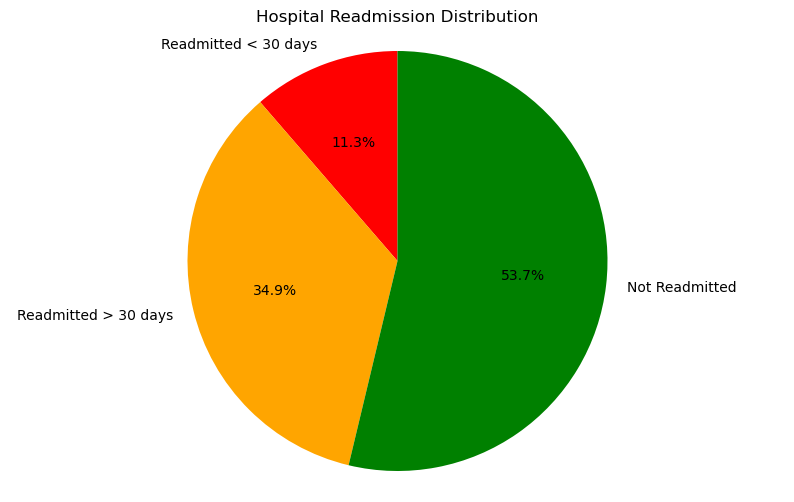

In [62]:
plt.figure(figsize=(10, 6))
labels = ['Readmitted < 30 days', 'Readmitted > 30 days', 'Not Readmitted']
sizes = [readmitted_less_30, readmitted_more_30, df["readmitted"].count() - (readmitted_less_30 + readmitted_more_30)]
plt.pie(sizes, labels=labels, colors=['red', 'orange', 'green'],autopct='%1.1f%%',startangle=90)
plt.axis('equal') 
plt.title('Hospital Readmission Distribution')
plt.show()


### 4.2. Readmission Distribution by Age group

In [65]:
readmission_by_agegroup=(df.groupby('age')['readmitted'].value_counts(normalize=True).unstack() * 100)
print(readmission_by_agegroup)

readmitted        <30        >30         NO
age                                        
[0-10)       1.666667  21.666667  76.666667
[10-20)      6.864989  34.553776  58.581236
[20-30)     14.285714  30.191458  55.522828
[30-40)     11.432161  32.066583  56.501256
[40-50)     10.843373  34.204819  54.951807
[50-60)      9.770688  34.317049  55.912263
[60-70)     11.361564  35.062304  53.576132
[70-80)     11.978100  35.907594  52.114306
[80-90)     12.125879  36.243723  51.630398
[90-100)    11.212247  29.333885  59.453868


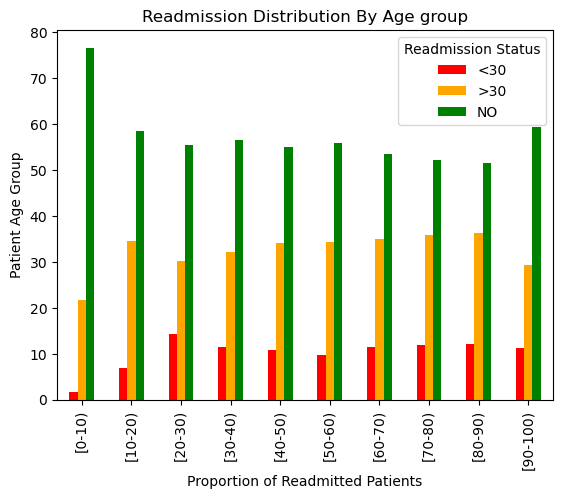

In [67]:
readmission_by_agegroup.plot(kind='bar', color=['red', 'orange', 'green'], stacked=False)
plt.xlabel("Proportion of Readmitted Patients")
plt.ylabel("Patient Age Group")
plt.title("Readmission Distribution By Age group")
plt.legend(title="Readmission Status")
plt.xticks(rotation=90)
plt.show()

### 4.3 Readmission rate by Admision type.


Admission status is coded as follows:
	1	Emergency
	2	Urgent
	3	Elective
	4	Newborn
	7	Trauma Center

Analysis focused on the 4 valid admission type categories

In [71]:
#Mapping each admission type to its label
admission_labels = {
    1: 'Emergency',
    2: 'Urgent',
    3: 'Elective',
    4: 'Newborn',
    7: 'Trauma Center'}

df['admission_type'] = df['admission_type_id'].map(admission_labels)

#Calculating Counts
counts = pd.crosstab(df['admission_type'], df['readmitted'])
print("COUNTS:")
print(counts)
print("\n")

#Calculating Percentages
percentages = pd.crosstab(df['admission_type'], df['readmitted'], normalize='index') * 100
print("PERCENTAGES:")
print(percentages.round(2))

COUNTS:
readmitted       <30    >30     NO
admission_type                    
Elective        1915   5589  10689
Emergency       6063  18821  27294
Newborn            1      2      7
Trauma Center      0      0     20
Urgent          1996   6296   9251


PERCENTAGES:
readmitted        <30    >30      NO
admission_type                      
Elective        10.53  30.72   58.75
Emergency       11.62  36.07   52.31
Newborn         10.00  20.00   70.00
Trauma Center    0.00   0.00  100.00
Urgent          11.38  35.89   52.73


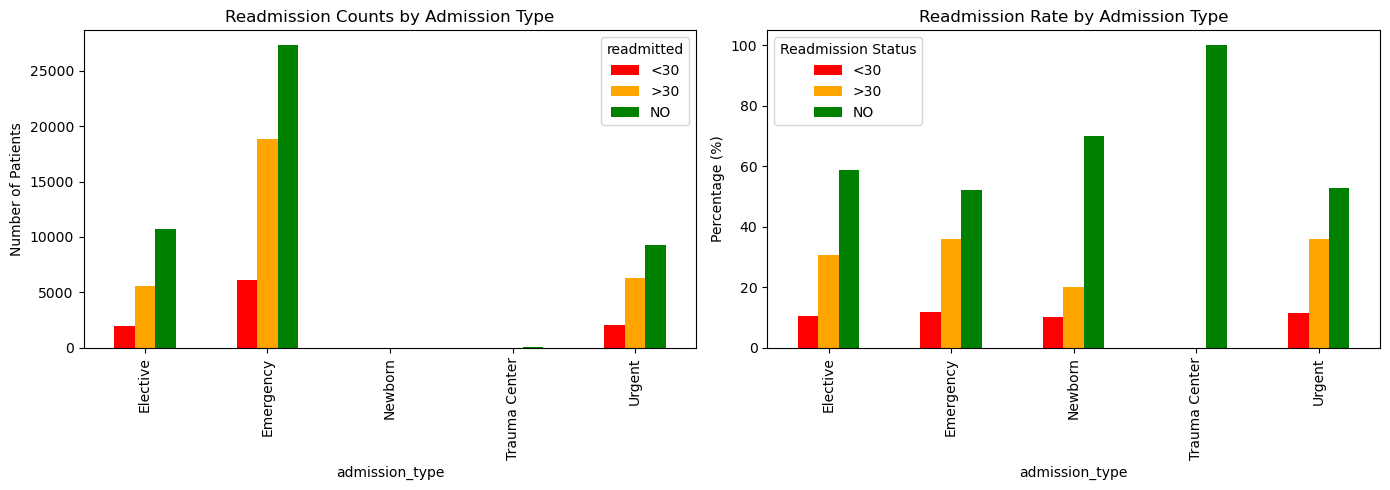

In [73]:
#Using a dual chart to accurately convey the volume and rate differences better.

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

colors=['red', 'orange', 'green']

counts.plot(kind='bar', ax=ax1, color=colors)
ax1.set_title('Readmission Counts by Admission Type')
ax1.set_ylabel('Number of Patients')

percentages.plot(kind='bar', ax=ax2, color=colors)
ax2.set_title('Readmission Rate by Admission Type')
ax2.set_ylabel('Percentage (%)')

plt.legend(title='Readmission Status')
plt.tight_layout()
plt.show()

Emergency admissions represent the highest burden of admissions, accounting for 59% of total patients, and with a readmission rate of 48% compared to planned elective procedures (41%). This 7 percentage point difference translates to 17% more readmissions. Urgent case readmissions at 47% performing similar to emergency cases suggests that unplanned admissions carry inherently higher risks.  
Clinically, this suggests that patients with poorly controlled diabetes with acute complications i.e those requiring emergency care, remain at elevated risk even after discharge.

### 4.4 Readmission by Number of Medications.

In [77]:
df.groupby('readmitted')['num_medications'].describe()

,count,mean,std,min,25%,50%,75%,max
readmitted,,,,,,,,
<30,9975.0,16.957694,8.139907,1.0,11.0,16.0,21.0,81.0
>30,30708.0,16.308063,7.632196,1.0,11.0,15.0,20.0,70.0
NO,47261.0,15.764922,8.465246,1.0,10.0,14.0,20.0,79.0


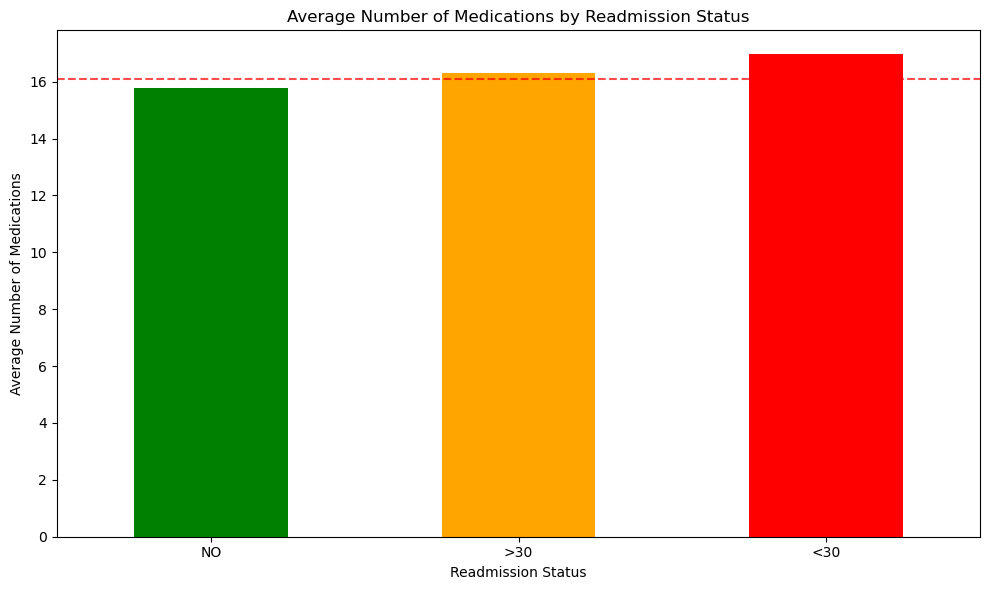

In [79]:
means = df.groupby('readmitted')['num_medications'].mean().sort_values()

means.plot(kind='bar', figsize=(10, 6), color=['green', 'orange', 'red'])
plt.title('Average Number of Medications by Readmission Status')
plt.xlabel('Readmission Status')
plt.ylabel('Average Number of Medications')
plt.xticks(rotation=0)
plt.axhline(y=df['num_medications'].mean(), color='red', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Number of medications show a modest association with readmission risk. Patients readmitted within 30 days averaged 17 medications versus 16 for those not readmitted. This suggests that patients with more complex conditions may be at higher risk of `readmissions. The overlapping distributions however suggest polypharmacy alone is not a strong standalone predictor.

### 4.5. Patients on Diabetes medication vs Readmission status

In [83]:
print("PATIENTS ON DIABETES MEDICATION:")
print(df['diabetesMed'].value_counts())
print("\n")

print("BREAKDOWN BY READMISSION")
counts_dm= pd.crosstab(df['diabetesMed'], df['readmitted'])
print("COUNTS:")
print(counts_dm)
print("\n")

percentages_dm= pd.crosstab(df['diabetesMed'], df['readmitted'], normalize= 'index')*100
print("PERCENTAGES:")
print(percentages_dm)
print("\n")

PATIENTS ON DIABETES MEDICATION:
diabetesMed
Yes    67631
No     20313
Name: count, dtype: int64


BREAKDOWN BY READMISSION
COUNTS:
readmitted    <30    >30     NO
diabetesMed                    
No           1985   6279  12049
Yes          7990  24429  35212


PERCENTAGES:
readmitted         <30        >30         NO
diabetesMed                                 
No            9.772067  30.911239  59.316694
Yes          11.814109  36.121010  52.064881




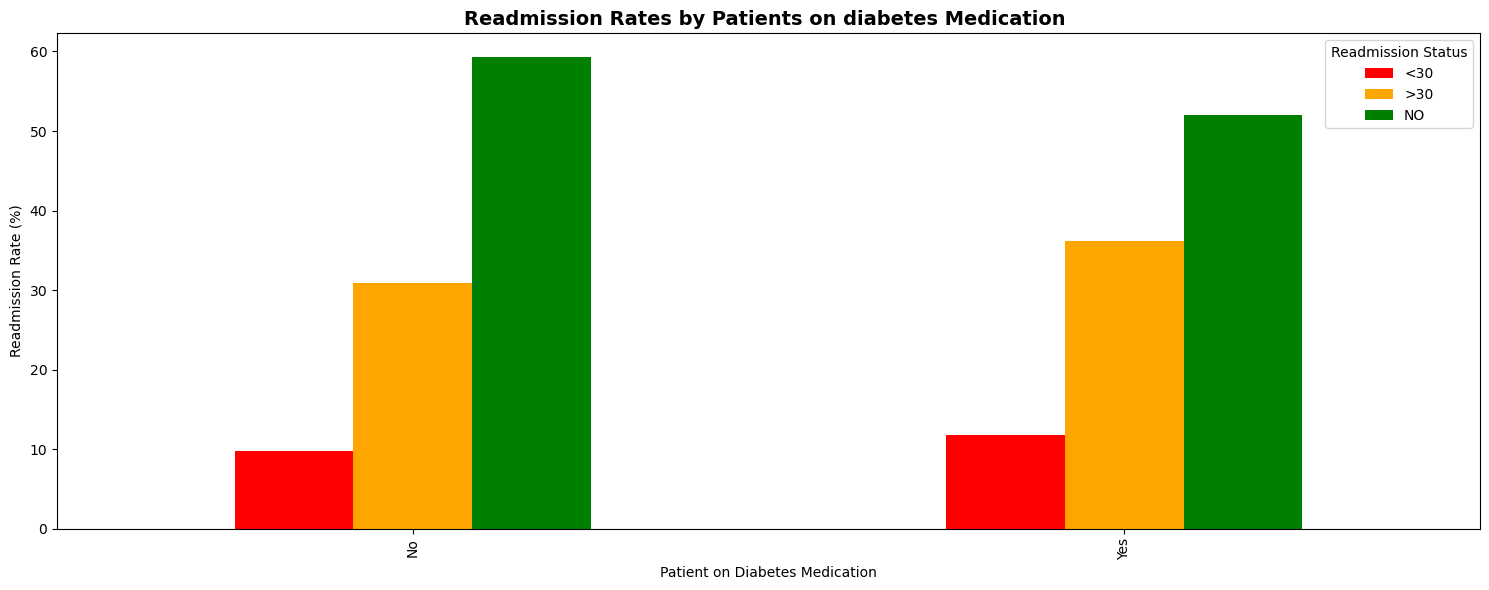

In [85]:
percentages_dm.plot(kind='bar', figsize=(15, 6), color=['red', 'orange', 'green'])
plt.title('Readmission Rates by Patients on diabetes Medication ', fontsize=14, fontweight='bold')
plt.xlabel('Patient on Diabetes Medication')
plt.ylabel('Readmission Rate (%)')
#plt.xticks([0, 1], ['Changed', 'No Change'], rotation=0)
plt.legend(title='Readmission Status')
plt.tight_layout()
plt.show()

Patients on diabetes medication showed a 48% readmission rate with higher <30 rates compared to 41% for those not on diabetes medication. Rather than indicating treatment failure, this may suggest that medication use is a marker of disease severity.   Patients requiring pharmacological intervention likely have more advanced or poorly controlled diabetes as opposed to those managing diabetes through lifestyle modifications alone. 

### 4.6. Change in Diabetes medication vs Readmission status

In [89]:
print("BREAKDOWN BY READMISSION:")
counts_ch= pd.crosstab(df['change'], df['readmitted'])
print("COUNTS:")
print(counts_ch)
print("\n")

percentages_ch= pd.crosstab(df['change'], df['readmitted'], normalize='index')*100
print("PERCENTAGES:")
print(percentages_ch)
print("\n")

df['is_readmitted'] = df['readmitted'].isin(['<30', '>30'])
overall_pct = df.groupby('change')['is_readmitted'].mean() * 100

print("OVERALL PERCENTAGE:")
print(overall_pct)

BREAKDOWN BY READMISSION:
COUNTS:
readmitted   <30    >30     NO
change                        
Ch          4908  14912  20871
No          5067  15796  26390


PERCENTAGES:
readmitted        <30        >30         NO
change                                     
Ch          12.061635  36.646924  51.291440
No          10.723129  33.428565  55.848306


OVERALL PERCENTAGE:
change
Ch    48.708560
No    44.151694
Name: is_readmitted, dtype: float64


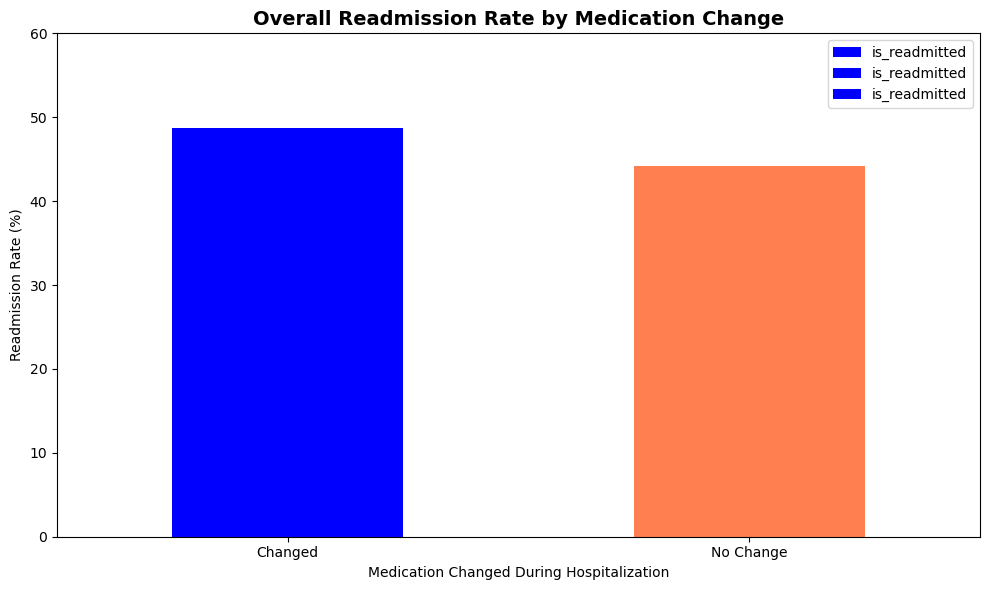

In [98]:
overall_pct.plot(kind='bar', figsize=(10, 6), color=['blue', 'coral'])
plt.title('Overall Readmission Rate by Medication Change', fontsize=14, fontweight='bold')
plt.xlabel('Medication Changed During Hospitalization')
plt.ylabel('Readmission Rate (%)')
plt.xticks([0, 1], ['Changed', 'No Change'], rotation=0)
plt.legend()
plt.ylim(0, 60)
plt.tight_layout()
plt.show()

Patients whose medications were changed during hospitalization had a 4.5 percentage point higher readmission rate than those whose meds stayed the same(48.7% vs 44.2%). This may idicate that change in medications are a marker of disease severity or patient instability requiring escalation of care. Alternatively, new regimens require an adjustment period where patients are vulnerable to compliance issues or side effects. Either way, this finding highlights the importance of post-discharge medication management and follow-up.

## 5. Key Findings

After analyzing 88,000+ patient records, a key pattern emerged;  
### 5.1 *DIsease severity and poorly controled diabetes are primary drivers of 30-day readmission risk*
Independent findins which led to this conclusion include:

**Unplanned Admissions(Emergency and Urgent care) as a Severity Marker.**
Emergency admissions show a 48% readmission rate compared to 41% for elective encounters. Clinically, patients with acute diabetes complications (e.g DKA,HHS,Hypoglycemia) necessitating Emergency care, remain at elevated risk even after discharge because the underlying disease severity still persisits. 

**Medication Patterns Reflect High Disease Burden**
-Patients on diabetes medication: 48% readmission rate with higher <30 rates vs 41% for those not on medication.
-Medication change during hospitalization: 48.7% vs 44.2% for stable regimens.
-Higher medication counts: 17 meds (readmitted) vs 16 meds (not readmitted).

*These are interconnected markers of the same issue, that patients requiring pharmacologicinterv ention, treatment modification, or those with comorbidities have more severe or poorly controlled diabetes.*

**Age-Related Vulnerabilities**
Readmission patterns varied by age group. Young adults (20-30) showed the highest early readmission rates, potentially reflecting adherence challenges or lifestyle factors. Older patients (70-80) experienced more delayed readmissions, possibly due to comorbidity progression. Pediatric patients (10-20) demonstrated the lowest overall readmission rates, suggesting either milder disease or more structured family-based care.

### 5.2 Clinical Implications

**Risk Stratification Strategy**
Diabetic patients should not be treated similarly at discharge, healthcare systems should identify high-severity markers:
- Emergency admission pathway
- Complex medication regimens (15+ medications)
- Medication changes during hospitalization
- Requiring diabetes medication (vs lifestyle management)

**Targeted Interventions**
Patients with multiple severity markers should receive:
- Intensive discharge planning and education
- Early post-discharge follow-up
- Increased monitoring for adherence and complications

Since emergency admissions represent 59% of volume with the highest readmission rates, even modest improvements in emergency admission outcomes would have substantial population-level impact on overall readmission burden.

### 5.3 What Doesn't Predict Strongly

Notably, some expected predictors showed weaker associations:
- Admission type differences were modest (7 percentage points)
- Medication count alone showed high variability within groups
- All readmission rates clustered in the 40-50% range

This suggests readmission is fundamentally a disease severity problem, not due to operational or procedural insufficiencies. Interventions focused solely on admission logistics or single factors are unlikely to succeed without addressing underlying diabetes control.
